In [1]:
import os
import numba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import entropy
from toolz import frequencies, sliding_window, compose, partial
from aging.dlight.windowing import window_trials_as_mtx
from aging.dlight.stats import bootstrap_lineplot, bootstrap_ci
from aging.behavior.syllables import relabel_by_usage
from aging.plotting import legend, format_plots, figure, save_factory, PlotConfig

from toolz import partial
from tqdm.auto import tqdm
from aging.dlight.normalize import rolling_fluor_normalization

In [2]:
numba.set_num_threads(int(os.environ.get("SLURM_JOB_CPUS_PER_NODE", 1)))

In [3]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "dlight", tight_layout=False)

In [4]:
version = 12
file = Path(
    f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/dlight_photometry_df_filter_stats_da_paper.parquet"
)

In [5]:
def compute_tm(df, max_syll=100):
    freq_dict = frequencies(sliding_window(2, df['relabeled_syllables'].to_numpy()))
    arr = np.zeros((max_syll, ) * 2)
    for k, v in freq_dict.items():
        arr[k] = v
    return arr


def compute_entropy(tm, count_thresh=30, v2=False):
    keep = np.where(tm.sum(1) >= count_thresh)[0]
    if v2:
        ent = entropy(tm[keep][:, keep] + 1, axis=1)
    else:
        ent = entropy(tm[keep] + 1, axis=1)
    ser = pd.Series(dict(zip(keep, ent)), name='entropy')
    ser.index.name = 'syllables'
    return ser

In [6]:
def zscore(arr):
    return (arr - arr.mean()) / arr.std()

In [ ]:
df = pd.read_parquet(file)
df['syllables'] = df['syllables'].ffill().astype(int)
df['onsets'] = (df['syllables'].diff() != 0).fillna(True).astype(bool)

In [12]:
norm_func = partial(rolling_fluor_normalization, window_size=10, quantile=0.5)
df['dlight_reref_zscore'] = norm_func(df['dlight_dff'] - df['uv_reference_fit'])

In [14]:
df = df.query('syllables != -5').copy()

In [15]:
df = relabel_by_usage(df, return_map=False)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8248636 entries, 5 to 8249400
Data columns (total 23 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   pmt00_ref00 (dLight)        float64       
 1   pmt00_ref01 (UV)            float64       
 2   timestamp                   float64       
 3   raw_timestamp               float64       
 4   fs                          float64       
 5   ir_indices                  float64       
 6   subject_name                object        
 7   session_name                object        
 8   start_time                  datetime64[us]
 9   syllables                   int64         
 10  velocity                    float64       
 11  uuid                        object        
 12  dlight_dff                  float64       
 13  uv_dff                      float64       
 14  dlight_reref                float64       
 15  uv_reference_fit            float64       
 16  dlight_reref_zscore    

In [17]:
df['syllable_index'] = df['onsets'].cumsum()

In [18]:
df['subject_name'].unique()

array(['98w-4', '98w-3', '98w-1', '52w-2', '52w-1', '52w-3', '52w-4',
       '12w-2', '12w-4', '12w-3', '98w-5', '12w-5', '52w-5', '98w-2',
       '12w-6', '12w-7'], dtype=object)

In [19]:
df['age'] = df['subject_name'].transform(lambda x: x.split('-')[0])

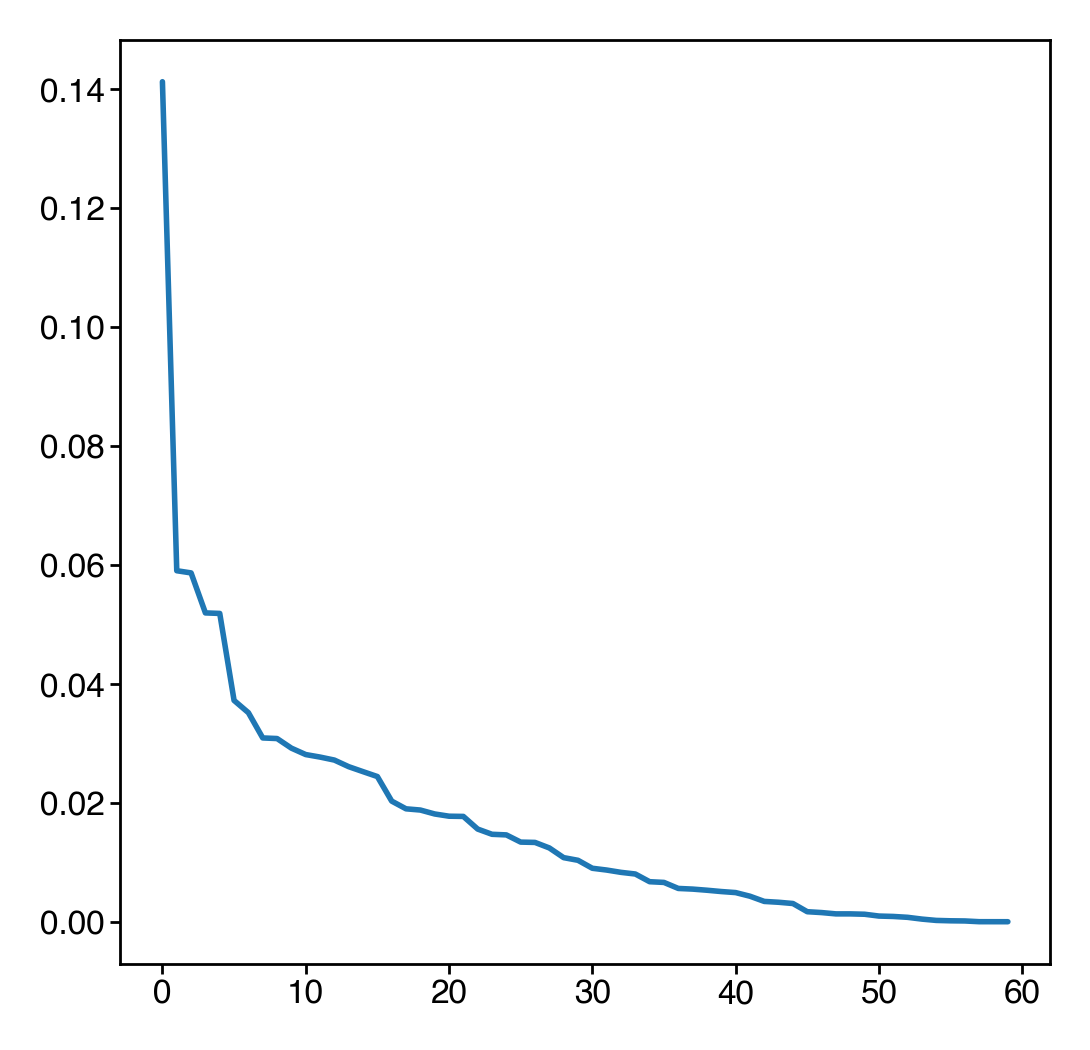

In [20]:
plt.plot(df.query('onsets')['syllables'].value_counts(normalize=True).reset_index(drop=True))

## Velocity

In [405]:
vel_dlight = df.groupby(['subject_name', 'uuid', 'relabeled_syllables', 'age', 'syllable_index'])[['velocity', 'dlight_reref_zscore']].mean()
vel_dlight = vel_dlight.groupby(['age', 'subject_name', 'uuid', 'relabeled_syllables']).mean()
vel_dlight = vel_dlight.query('velocity < 50')
# vel_dlight = vel_dlight.groupby(['age', 'subject_name', 'relabeled_syllables']).mean()
# vel_dlight['dlight_reref_zscore'] = vel_dlight.groupby('uuid')['dlight_reref_zscore'].transform(zscore)
# vel_dlight['velocity'] = vel_dlight.groupby('uuid')['velocity'].transform(zscore)

In [407]:
vel_dlight.loc['12w'].corr()

,velocity,dlight_reref_zscore
velocity,1.000000,-0.106645
dlight_reref_zscore,-0.106645,1.000000


In [408]:
vel_dlight.loc['52w'].corr()

,velocity,dlight_reref_zscore
velocity,1.000000,-0.041117
dlight_reref_zscore,-0.041117,1.000000


In [409]:
vel_dlight.loc['98w'].corr()

,velocity,dlight_reref_zscore
velocity,1.000000,-0.048665
dlight_reref_zscore,-0.048665,1.000000


<Axes: xlabel='dlight_reref_zscore', ylabel='velocity'>

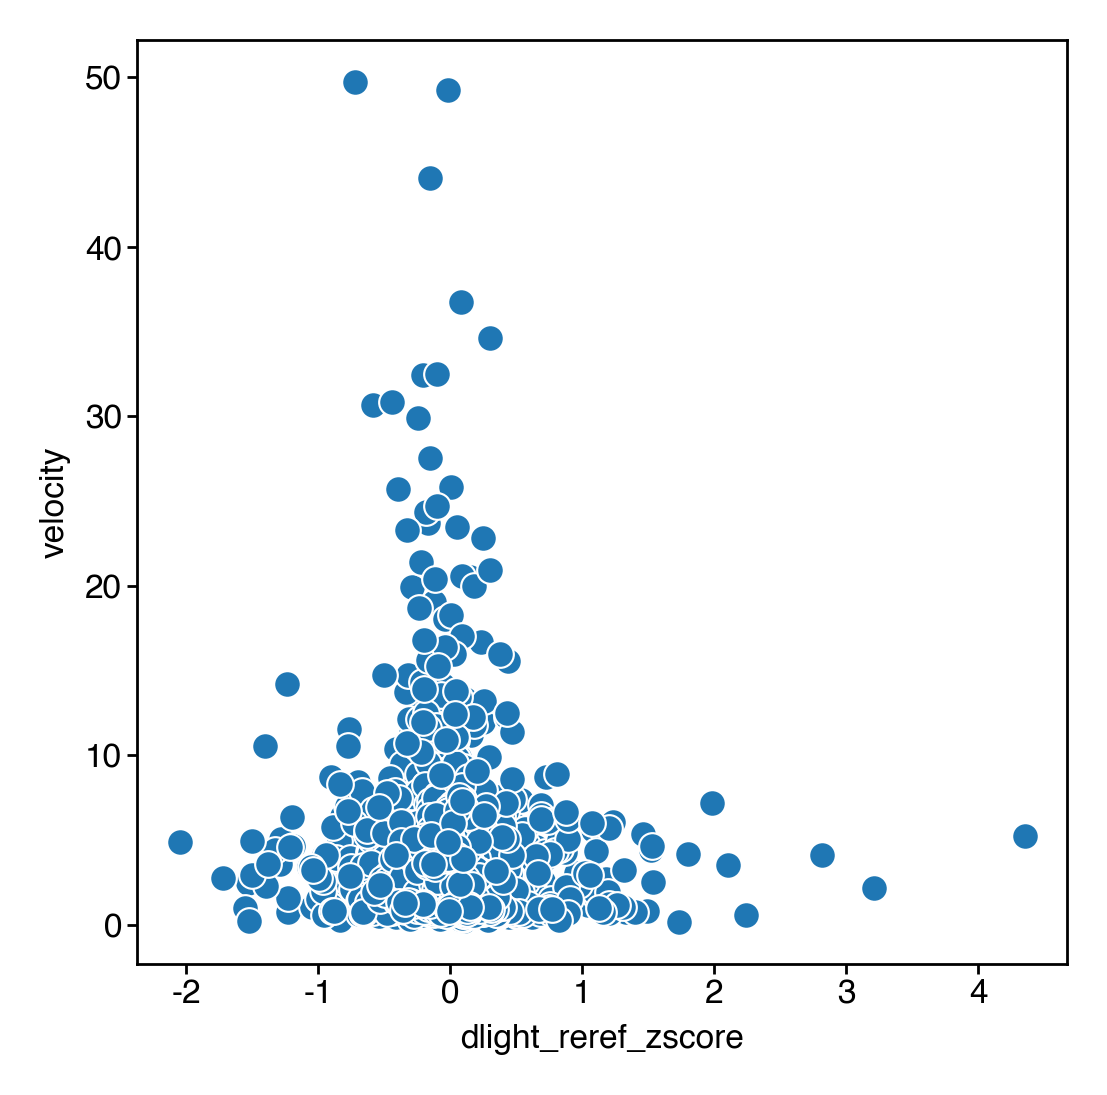

In [410]:
sns.scatterplot(data=vel_dlight.loc['12w'], x='dlight_reref_zscore', y='velocity')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8249401 entries, 0 to 8249400
Data columns (total 23 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   pmt00_ref00 (dLight)        float64       
 1   pmt00_ref01 (UV)            float64       
 2   timestamp                   float64       
 3   raw_timestamp               float64       
 4   fs                          float64       
 5   ir_indices                  float64       
 6   subject_name                object        
 7   session_name                object        
 8   start_time                  datetime64[us]
 9   syllables                   int64         
 10  velocity                    float64       
 11  uuid                        object        
 12  dlight_dff                  float64       
 13  uv_dff                      float64       
 14  dlight_reref                float64       
 15  uv_reference_fit            float64       
 16  dlight_reref_zscor

In [104]:
snr_stats = df.groupby('uuid')['snr'].agg(['max', 'mean', 'min'])
mc_stats = df.groupby('uuid')['session_motion_corr'].agg(['max', 'mean', 'min'])

<Axes: xlabel='max', ylabel='Probability'>

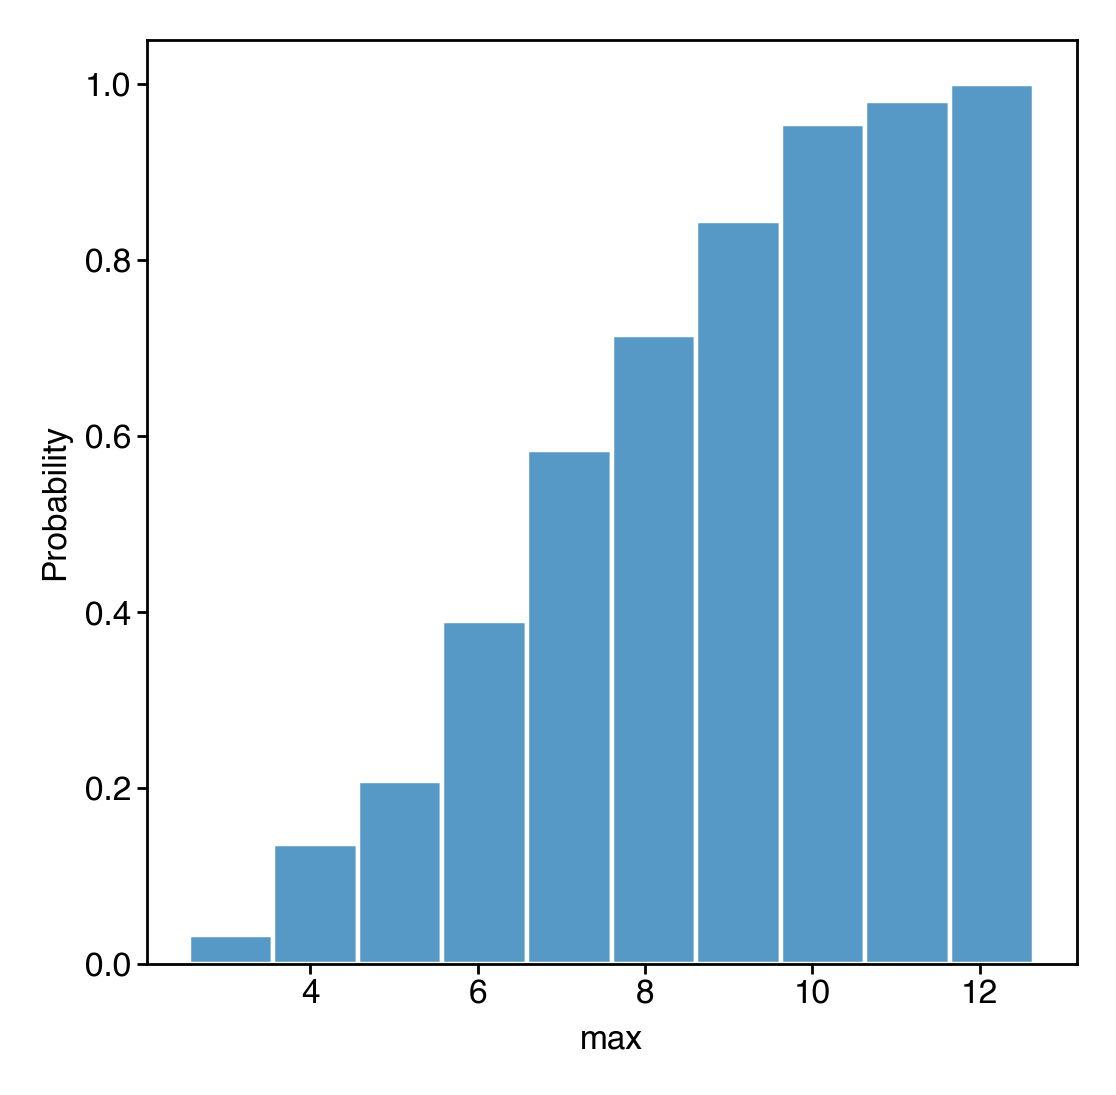

In [103]:
sns.histplot(snr_stats['max'], cumulative=True, stat='probability')

<Axes: xlabel='max', ylabel='Probability'>

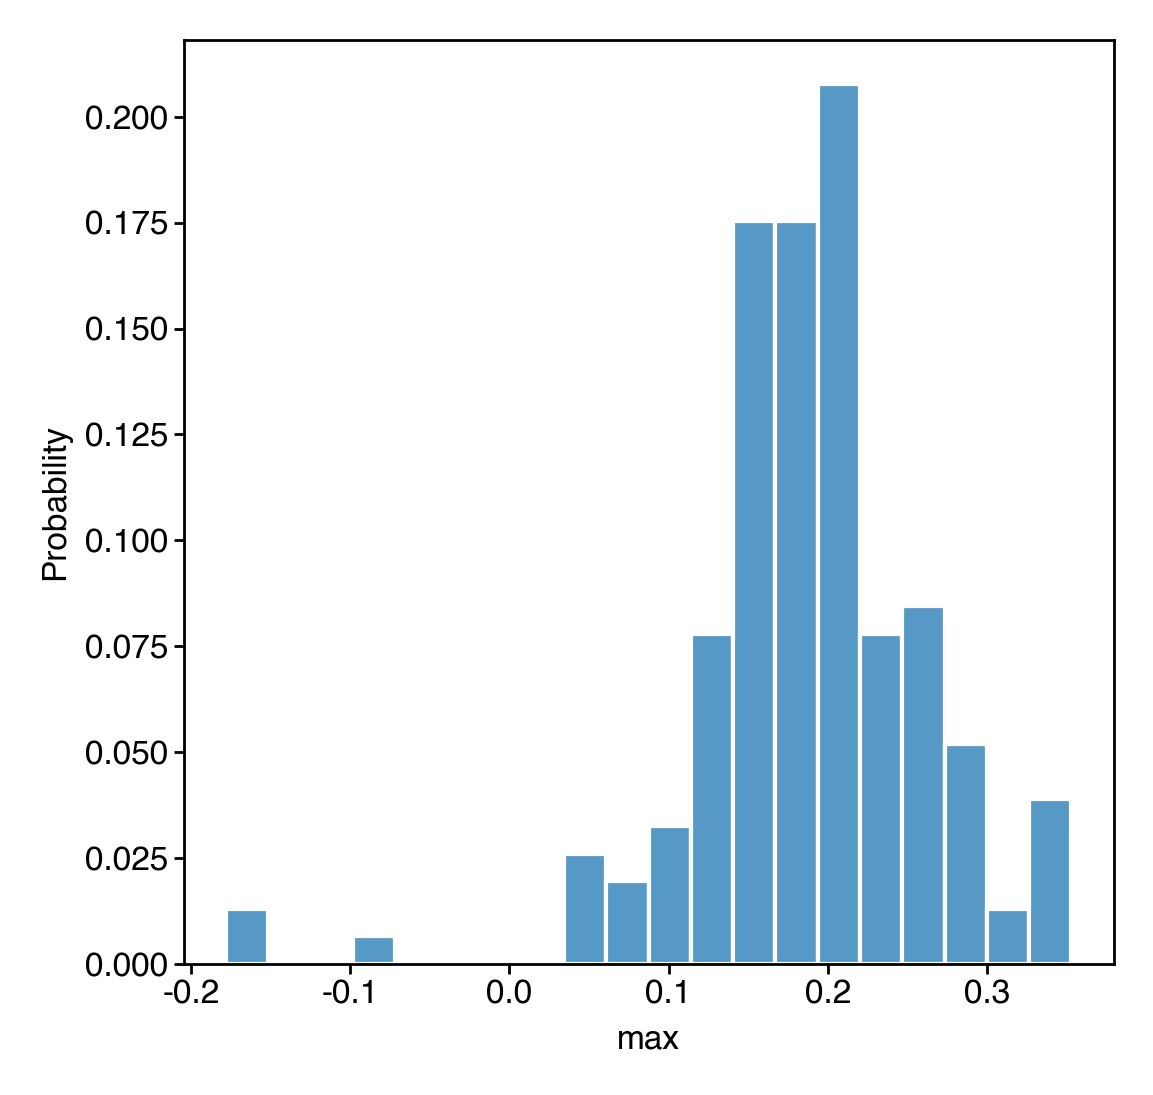

In [106]:
sns.histplot(mc_stats['max'], stat='probability')

In [21]:
filt_df = df.query('snr > 5 & session_motion_corr < 0.25 & session_motion_corr > 0')

webf NOT subset; don't know how to subset; dropped


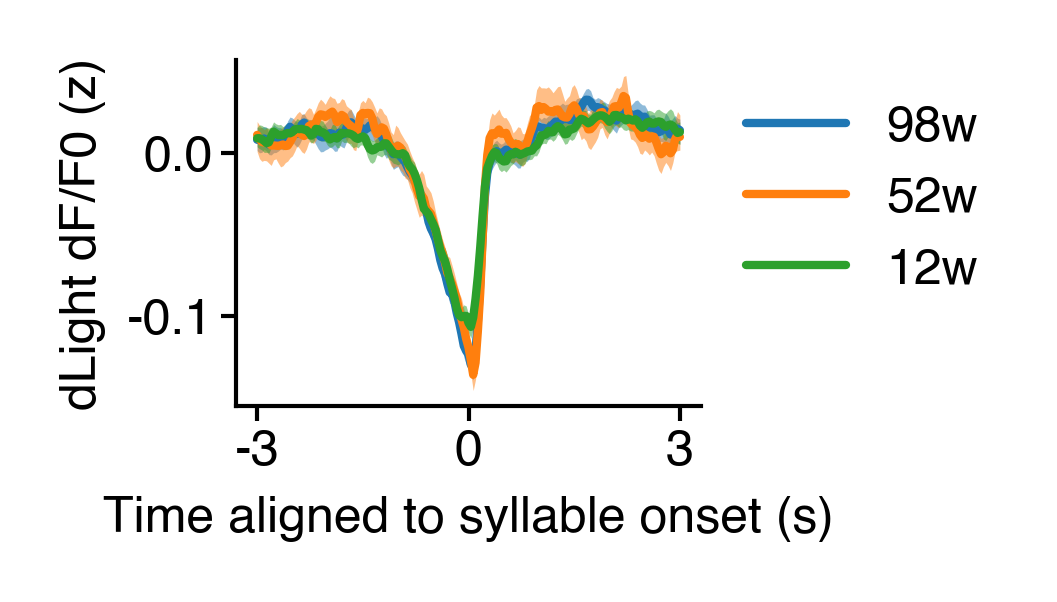

In [13]:
fig = figure(1, 0.75)
for age, _df in filt_df.groupby("age", sort=False):
    time, mtx = window_trials_as_mtx(
        _df,
        np.where(_df["onsets"])[0],
        "dlight_reref_zscore",
        truncation_window=(-3, 3),
    )
    mus = bootstrap_ci(mtx.astype("float32"), n_boots=50)
    ax = bootstrap_lineplot(time, mus, label=age)
ax.set(ylabel="dLight dF/F0 (z)", xlabel="Time aligned to syllable onset (s)", xticks=[-3, 0, 3])
sns.despine()
legend(ax)
saver(fig, "dlight-aligned-waveforms-across-age");

## Next stage

In [22]:
syllables = filt_df['syllables'].unique()

In [23]:
def get_peak_height(df, syllable_col="relabeled_syllables"):
    peaks = {}
    mask = df["onsets"]
    for syll in df[syllable_col].unique():
        syll_mask = df[syllable_col] == syll
        time, mtx = window_trials_as_mtx(
            df,
            np.where(mask & syll_mask)[0],
            "dlight_reref_zscore",
            truncation_window=(0, 0.3),
        )
        maxes = np.nanmax(mtx, axis=1)
        peaks[syll] = np.nanmean(maxes)
    ser = pd.Series(peaks, name="Peak DA")
    ser.index.name = "syllables"
    return ser

## Correlate syllable usage and dLight for each age

In [24]:
syll_counts = (
    filt_df.query("onsets")
    .groupby(["age", "subject_name", "uuid"])["relabeled_syllables"]
    .value_counts()
)
syll_counts.index = syll_counts.index.rename("syllables", level="relabeled_syllables")

In [25]:
out = filt_df.groupby(['age', 'subject_name', 'uuid']).apply(get_peak_height)

/tmp/ipykernel_15063/1073314887.py:13: RuntimeWarning: Mean of empty slice
  peaks[syll] = np.nanmean(maxes)
/tmp/ipykernel_15063/246629140.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = filt_df.groupby(['age', 'subject_name', 'uuid']).apply(get_peak_height)


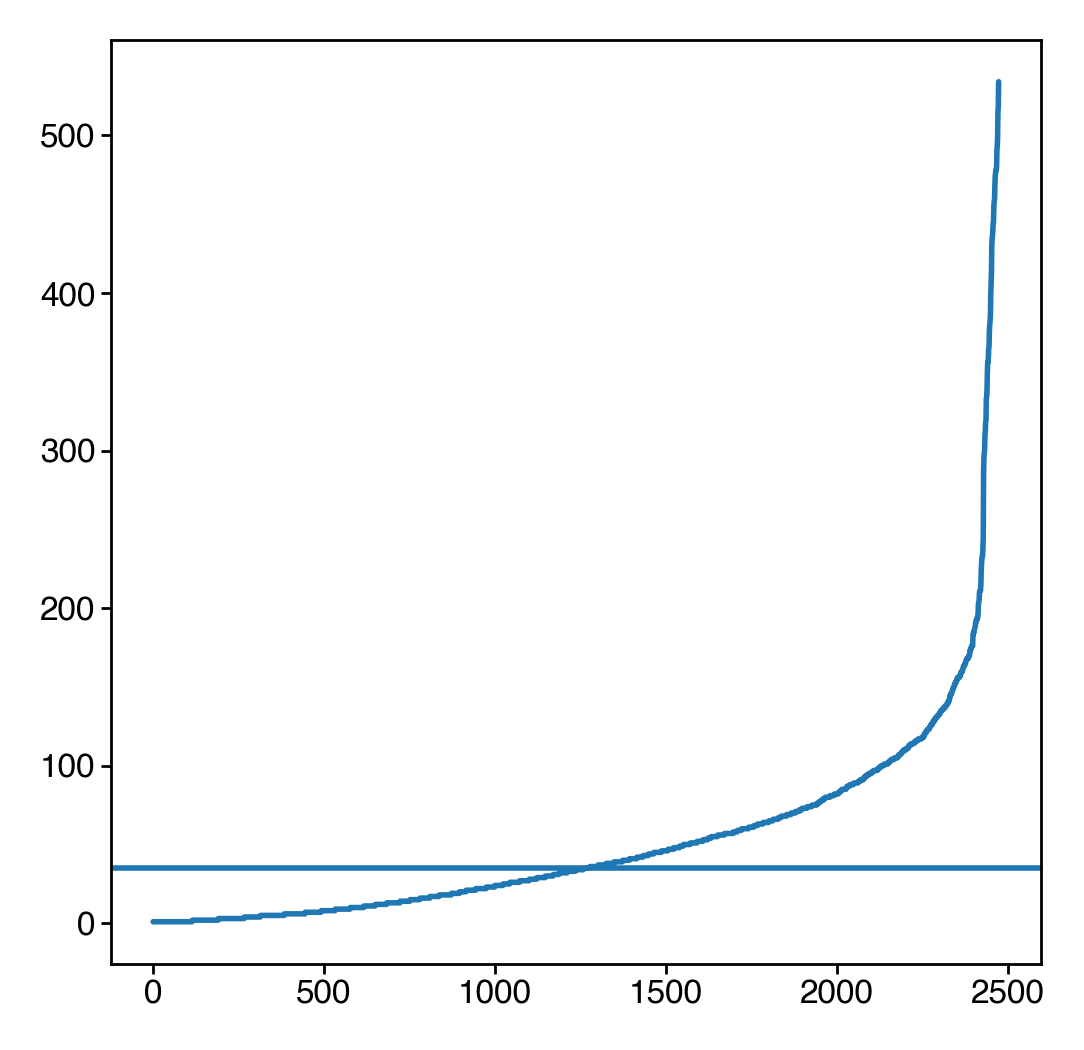

In [26]:
plt.plot(syll_counts.loc['12w'].sort_values().to_numpy())
plt.axhline(35)

In [115]:
da_usage = pd.DataFrame(syll_counts).join(out)
da_usage = da_usage.query('count > 60')
da_usage['Peak DA'] = da_usage.groupby('uuid')['Peak DA'].transform(zscore)
da_usage['count'] = da_usage.groupby('uuid')['count'].transform(zscore)
da_usage.groupby('age').corr(method='spearman')

count   Peak DA
age                            
12w count    1.000000  0.216590
    Peak DA  0.216590  1.000000
52w count    1.000000  0.281333
    Peak DA  0.281333  1.000000
98w count    1.000000  0.236154
    Peak DA  0.236154  1.000000

In [116]:
tmp = da_usage.groupby(['age', 'subject_name', 'syllables']).mean()
tmp.groupby('age').corr(method='spearman')

count   Peak DA
age                            
12w count    1.000000  0.257738
    Peak DA  0.257738  1.000000
52w count    1.000000  0.366316
    Peak DA  0.366316  1.000000
98w count    1.000000  0.106346
    Peak DA  0.106346  1.000000

In [42]:
thresholds = np.arange(0, 105, 5, dtype=int)

In [54]:
corrs = []
for thresh in thresholds:
    # da_usage = pd.DataFrame(syll_counts).join(out).drop(0, level="syllables")
    da_usage = pd.DataFrame(syll_counts).join(out)
    da_usage = da_usage.query('count >= @thresh')
    da_usage['Peak DA'] = da_usage.groupby('uuid')['Peak DA'].transform(zscore)
    # da_usage['count'] = da_usage.groupby('uuid')['count'].transform(zscore)
    tmp = da_usage.groupby(['age', 'subject_name', 'syllables']).mean()
    tmp = tmp.groupby('age').corr(method='spearman')
    tmp = tmp.loc[pd.IndexSlice[:, 'count'], 'Peak DA']
    tmp['thresh'] = int(thresh)
    corrs.append(tmp.droplevel(1))
corrs = pd.DataFrame(corrs).astype({"thresh": int}).set_index('thresh')

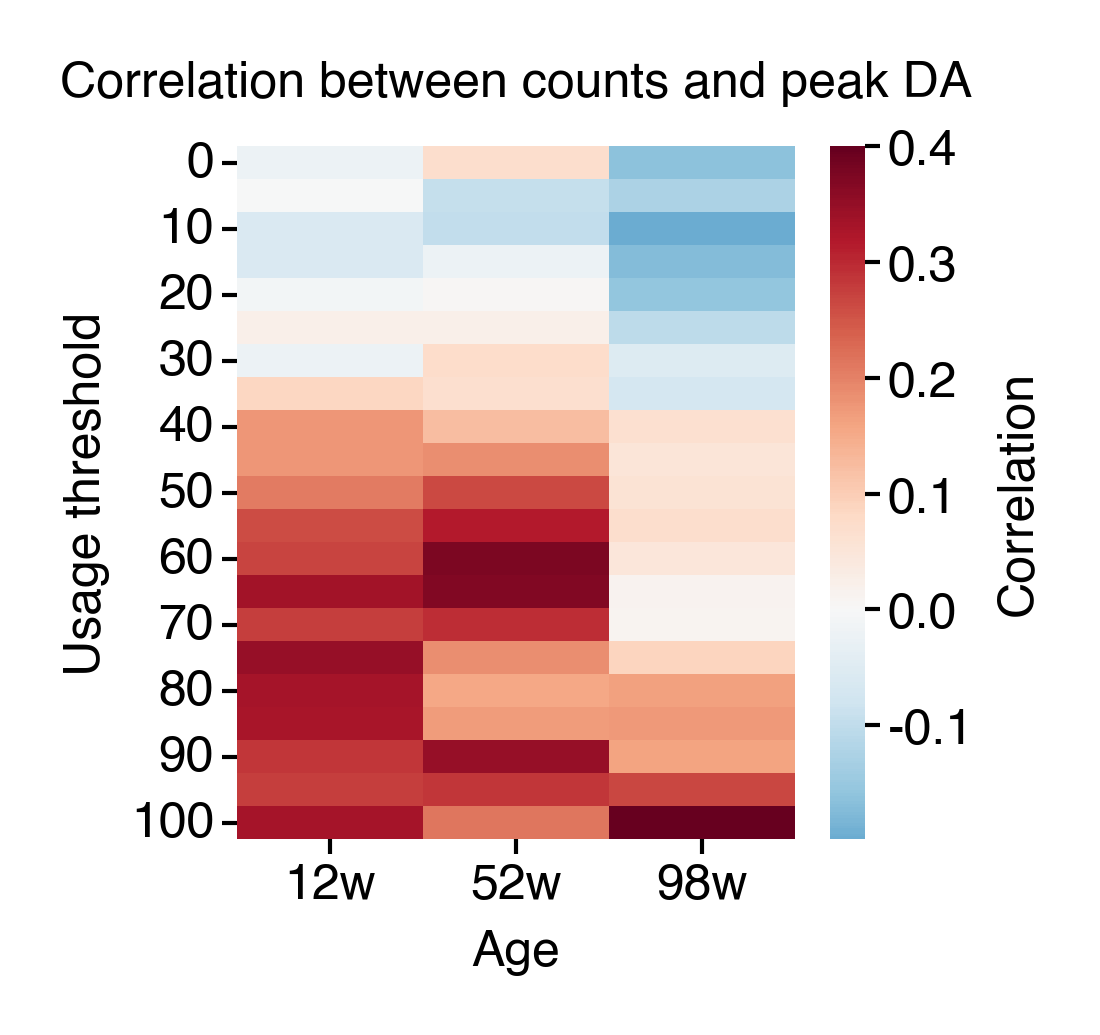

In [55]:
fig = figure(1.5, 1.5)
ax = sns.heatmap(corrs, cbar_kws=dict(label="Correlation"), cmap="RdBu_r", center=0, vmax=0.4)
ax.set(ylabel="Usage threshold", xlabel="Age", title="Correlation between counts and peak DA")
plt.yticks(rotation=0)
saver(fig, "counts-and-da-correlation-threshold-heatmap");

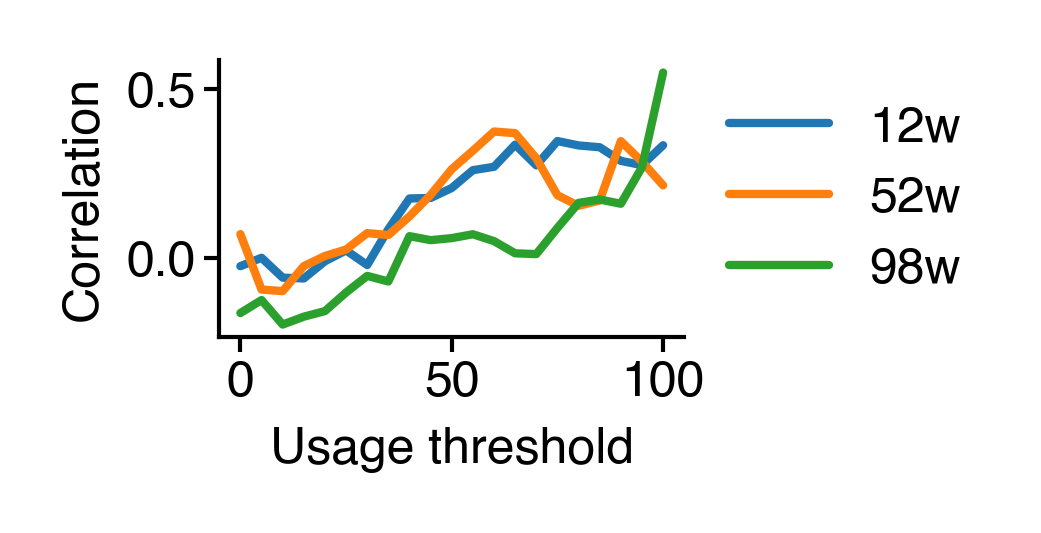

In [63]:
fig = figure(1, 0.6)
ax = fig.gca()
ax = corrs.plot(ax=ax)
ax.set(xlabel='Usage threshold', ylabel='Correlation')
legend()
sns.despine()
saver(fig, "counts-and-da-correlation-threshold-lineplot");

In [96]:
da_usage = pd.DataFrame(syll_counts).join(out)
da_usage = da_usage.query('count >= 70')
da_usage['Peak DA'] = da_usage.groupby('uuid')['Peak DA'].transform(zscore)
# da_usage['count'] = da_usage.groupby('uuid')['count'].transform(zscore)
tmp = da_usage.groupby(['age', 'subject_name', 'syllables']).mean()

In [97]:
tmp

count   Peak DA
age subject_name syllables                      
12w 12w-2        0          471.600000  0.831897
                 1          109.222222 -0.113863
                 2          139.700000  0.318923
                 3           84.428571  0.187203
                 4          107.666667  0.486688
...                                ...       ...
98w 98w-5        12          89.333333 -1.191791
                 13          76.500000 -0.938816
                 14          82.000000 -0.627135
                 15          88.000000 -1.190702
                 23          80.333333  0.775260

[284 rows x 2 columns]

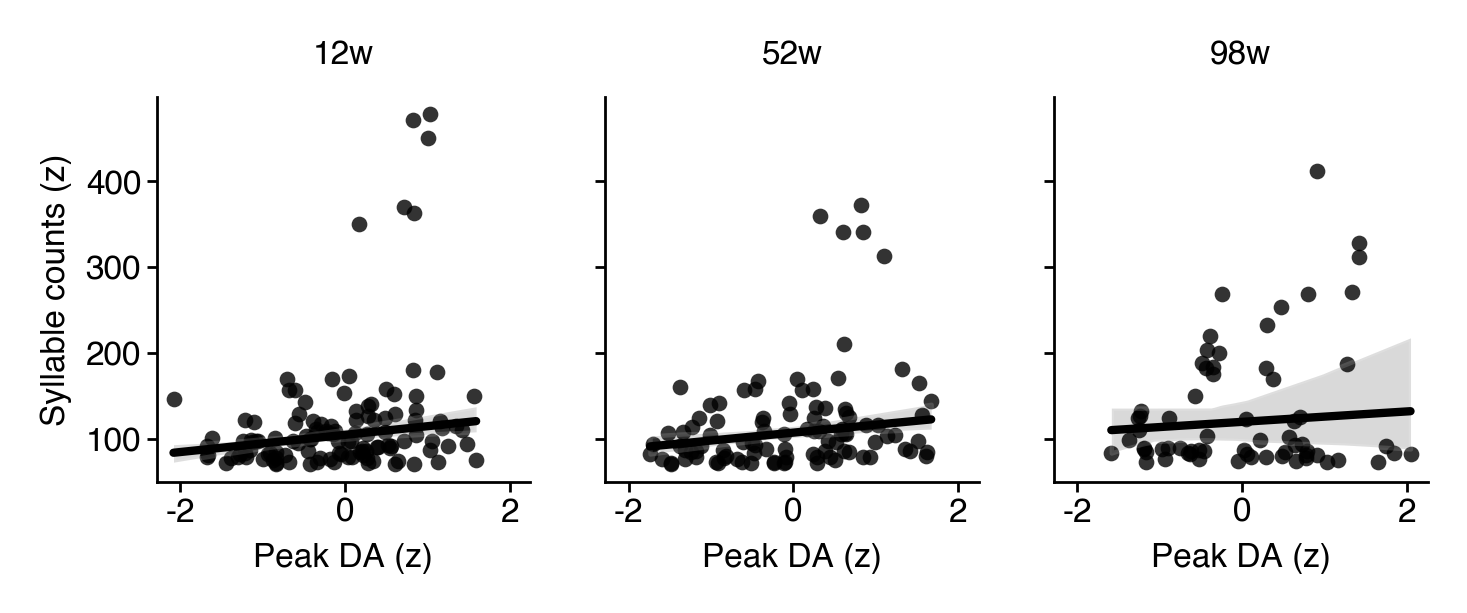

In [99]:
fig, ax = plt.subplots(1, 3, figsize=(4.1, 1.25), sharex=True, sharey=True)
for age, a in zip(("12w", "52w", "98w"), ax.flat):
    a = sns.regplot(
        data=tmp.loc[age],
        x="Peak DA",
        y="count",
        robust=True,
        color="k",
        scatter_kws=dict(linewidths=0, s=8),
        ax=a,
        n_boot=100
    )
    a.set(xlabel="Peak DA (z)", title=age, ylabel="")
ax[0].set(ylabel="Syllable counts (z)")
sns.despine()
saver(fig, "peak-da-vs-counts-scatter");

[Text(56.02722222222222, 0.5, 'Syllable counts'),
 Text(0.5, 32.999999999999986, 'Peak DA (z)')]

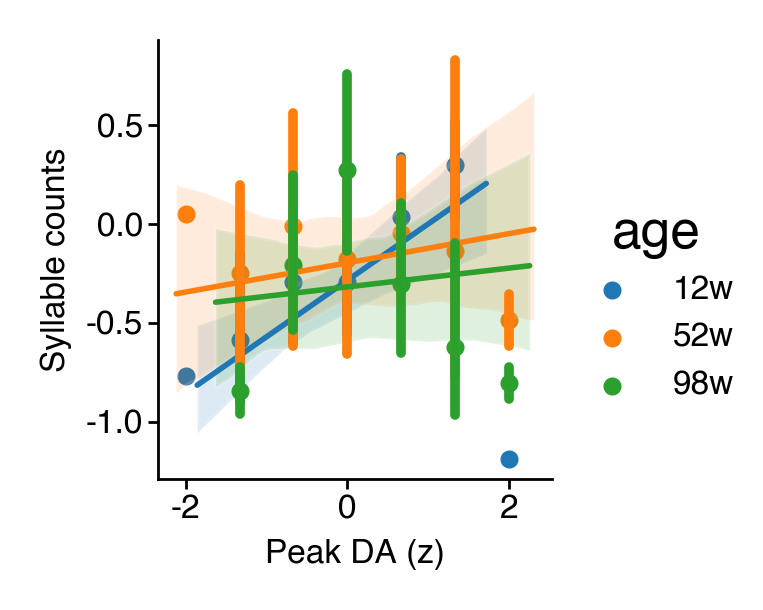

In [56]:
g = sns.lmplot(
    data=tmp.reset_index(),
    x="Peak DA",
    y="count",
    hue="age",
    x_bins=np.linspace(-2, 2, 7),
    height=1.5,
    aspect=1,
    scatter_kws=dict(s=6),
    line_kws=dict(lw=1),
    robust=True,
    n_boot=100,
)
g.ax.set(ylabel="Syllable counts", xlabel="Peak DA (z)")
# saver(g.fig, "dlight-vs-counts-vs-age");

In [57]:
filt_df.head()

,pmt00_ref00 (dLight),pmt00_ref01 (UV),timestamp,raw_timestamp,fs,ir_indices,subject_name,session_name,start_time,syllables,...,uv_reference_fit,dlight_reref_zscore,dlight_reref_zscore_filter,onsets,relabeled_syllables,session_motion_corr,snr,rolling_motion_corr,syllable_index,age
54000,0.026147,0.011056,0.000000,2.839133e+09,29.962547,0.0,98w-3,dlight-aging,2023-08-07 12:55:05.062630,-5,...,0.001491,1.150043,1.764906,True,46,0.109966,4.684033,NaN,2794,98w
54001,0.026044,0.011174,0.033375,2.839133e+09,29.962547,NaN,98w-3,dlight-aging,2023-08-07 12:55:05.062630,-5,...,0.004891,0.493352,1.213703,True,46,0.109966,4.684033,NaN,2795,98w
54002,0.026023,0.011264,0.066750,2.839133e+09,29.962547,1.0,98w-3,dlight-aging,2023-08-07 12:55:05.062630,-5,...,0.007885,0.153601,0.704451,True,46,0.109966,4.684033,NaN,2796,98w
54003,0.026032,0.011270,0.100062,2.839134e+09,29.962547,NaN,98w-3,dlight-aging,2023-08-07 12:55:05.062630,-5,...,0.010259,0.038547,0.255265,True,46,0.109966,4.684033,NaN,2797,98w
54004,0.025958,0.011242,0.133375,2.839134e+09,29.962547,2.0,98w-3,dlight-aging,2023-08-07 12:55:05.062630,-5,...,0.012030,-0.372114,-0.133419,True,46,0.109966,4.684033,NaN,2798,98w


## Correlate entropy

In [64]:
thresholds = np.arange(0, 105, 5, dtype=int)

In [65]:
corrs = []
out = filt_df.groupby(['age', 'subject_name', 'uuid']).apply(get_peak_height)
for thresh in tqdm(thresholds):
    # the lambda function removes the first syllable
    fun = compose(
        # partial(compute_entropy, count_thresh=thresh, v2=True), lambda v: v[1:, 1:], partial(compute_tm, max_syll=60)
        partial(compute_entropy, count_thresh=thresh, v2=True), partial(compute_tm, max_syll=60)
    )
    ent_out = filt_df.query("onsets").groupby(["age", "subject_name", "uuid"]).apply(fun)
    if isinstance(ent_out, pd.DataFrame):
        ent_out = ent_out.reset_index().melt(id_vars=['age', 'subject_name', 'uuid'], value_name='entropy').set_index(['age', 'subject_name', 'uuid', 'syllables'])
    da_ent = pd.DataFrame(ent_out).join(out)
    da_ent['Peak DA'] = da_ent.groupby('uuid')['Peak DA'].transform(zscore)
    # da_ent['entropy'] = da_ent.groupby('uuid')['entropy'].transform(zscore)
    tmp = da_ent.groupby(['age', 'subject_name', 'syllables']).mean()
    tmp = tmp.groupby('age').corr(method='spearman')
    tmp = tmp.loc[pd.IndexSlice[:, 'entropy'], 'Peak DA']
    tmp['thresh'] = int(thresh)
    corrs.append(tmp.droplevel(1))
corrs = pd.DataFrame(corrs).astype({"thresh": int}).set_index('thresh')

/tmp/ipykernel_15063/1073314887.py:13: RuntimeWarning: Mean of empty slice
  peaks[syll] = np.nanmean(maxes)
/tmp/ipykernel_15063/3676174885.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = filt_df.groupby(['age', 'subject_name', 'uuid']).apply(get_peak_height)


  0%|          | 0/21 [00:00<?, ?it/s]

/tmp/ipykernel_15063/3676174885.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ent_out = filt_df.query("onsets").groupby(["age", "subject_name", "uuid"]).apply(fun)
/tmp/ipykernel_15063/3676174885.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ent_out = filt_df.query("onsets").groupby(["age", "subject_name", "uuid"]).apply(fun)
/tmp/ipykernel_15063/3676174885.py:9: DeprecationWarning: DataFrameGro

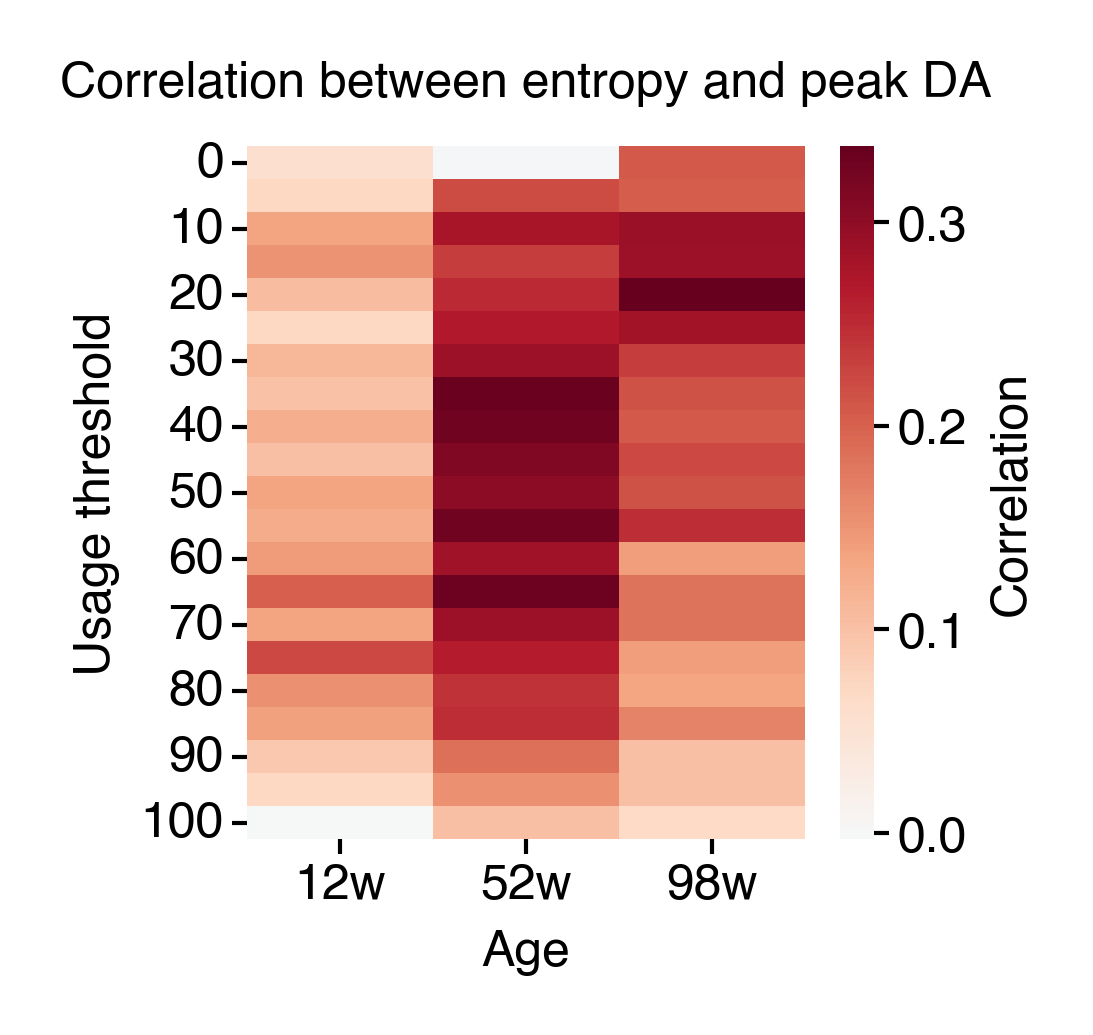

In [66]:
fig = figure(1.5, 1.5)
ax = sns.heatmap(corrs, cbar_kws=dict(label="Correlation"), cmap="RdBu_r", center=0)
ax.set(ylabel="Usage threshold", xlabel="Age", title="Correlation between entropy and peak DA")
plt.yticks(rotation=0)
saver(fig, "entropy-and-da-correlation-threshold-heatmap");

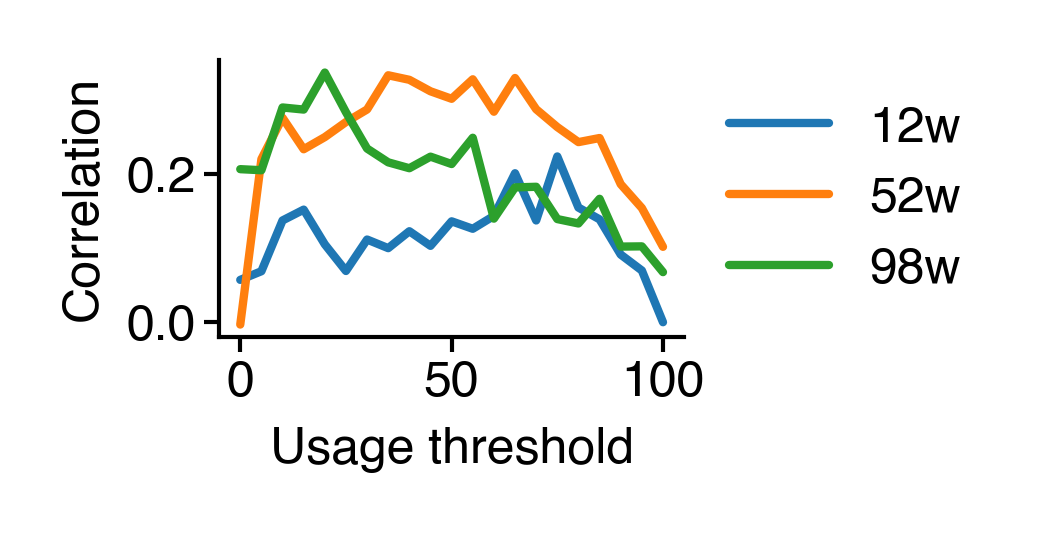

In [67]:
fig = figure(1, 0.6)
ax = fig.gca()
ax = corrs.plot(ax=ax)
ax.set(xlabel='Usage threshold', ylabel='Correlation')
legend()
sns.despine()
saver(fig, "entropy-and-da-correlation-threshold-lineplot");

[Text(51.841597222222205, 0.5, 'Entropy (nats)'),
 Text(0.5, 32.999999999999986, 'Peak DA (z)')]

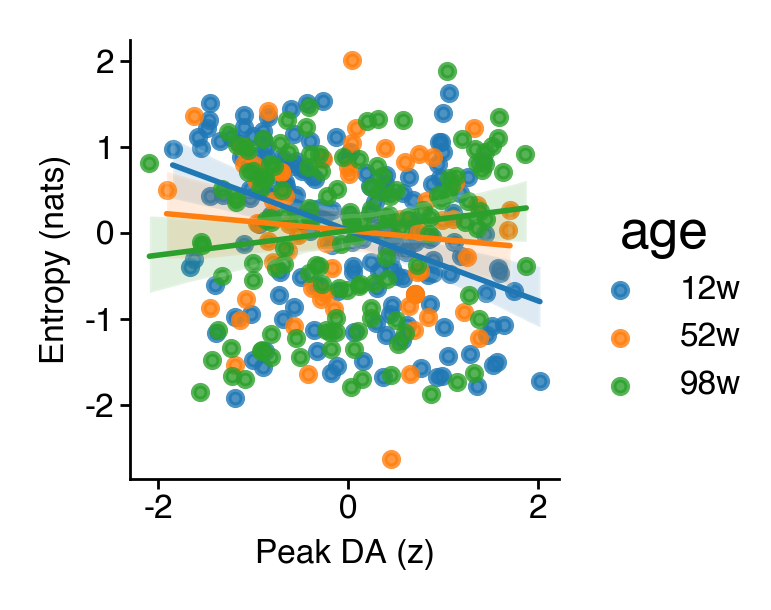

In [66]:
g = sns.lmplot(
    data=da_ent.reset_index(),
    x="Peak DA",
    y="entropy",
    hue="age",
    height=1.5,
    aspect=1,
    scatter_kws=dict(s=6),
    line_kws=dict(lw=1),
    robust=True,
    n_boot=400,
)
g.ax.set(ylabel="Entropy (nats)", xlabel="Peak DA (z)")

[Text(56.02722222222222, 0.5, 'Entropy (nats)'),
 Text(0.5, 32.999999999999986, 'Peak DA (z)')]

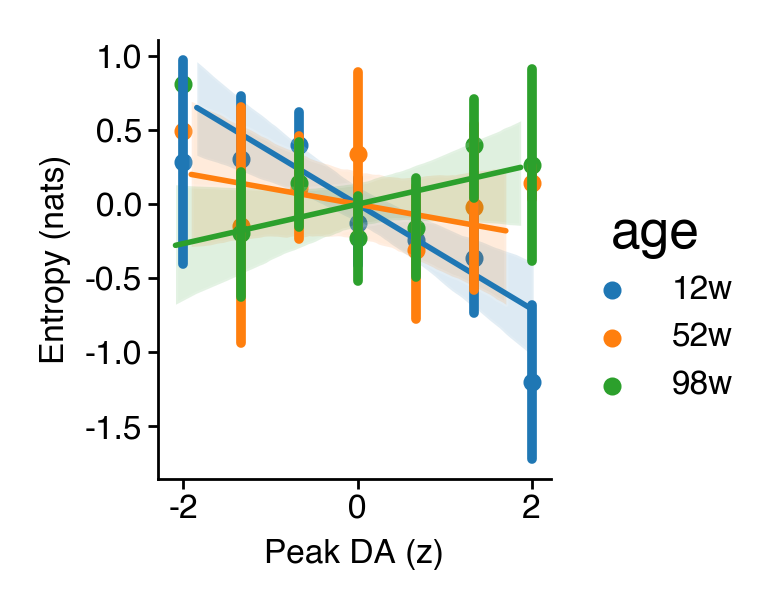

In [67]:
g = sns.lmplot(
    data=da_ent.reset_index(),
    x="Peak DA",
    y="entropy",
    hue="age",
    x_bins=np.linspace(-2, 2, 7),
    height=1.5,
    aspect=1,
    scatter_kws=dict(s=6),
    line_kws=dict(lw=1),
)
g.ax.set(ylabel="Entropy (nats)", xlabel="Peak DA (z)")
# saver(g.fig, "dlight-vs-entropy-vs-age");

## Bootstrap correlation values

In [68]:
out = filt_df.groupby(['age', 'subject_name', 'uuid']).apply(get_peak_height)

/tmp/ipykernel_15063/1073314887.py:13: RuntimeWarning: Mean of empty slice
  peaks[syll] = np.nanmean(maxes)
/tmp/ipykernel_15063/246629140.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = filt_df.groupby(['age', 'subject_name', 'uuid']).apply(get_peak_height)


In [83]:
da_usage = pd.DataFrame(syll_counts).join(out)
da_usage = da_usage.query('count >= 70')
da_usage['Peak DA'] = da_usage.groupby('uuid')['Peak DA'].transform(zscore)
# da_usage['count'] = da_usage.groupby('uuid')['count'].transform(zscore)

In [84]:
uuids = pd.Series(da_usage.index.get_level_values('uuid').unique())

In [87]:
correlation_bootstraps = []
for i in tqdm(range(1_000)):
    uuid_sample = uuids.sample(frac=1, replace=True, random_state=i)
    da_usage_sample = []
    for _uuid in uuid_sample:
        da_usage_sample.append(da_usage.loc[pd.IndexSlice[:, :, _uuid], :])
    da_usage_sample = pd.concat(da_usage_sample)
    tmp = da_usage_sample.groupby(['age', 'subject_name', 'syllables']).mean()
    tmp = tmp.groupby('age').corr(method='spearman')
    tmp = tmp.loc[pd.IndexSlice[:, 'count'], 'Peak DA'].droplevel(1)
    correlation_bootstraps.append(tmp)
correlation_bootstraps = pd.DataFrame(correlation_bootstraps)

  0%|          | 0/1000 [00:00<?, ?it/s]

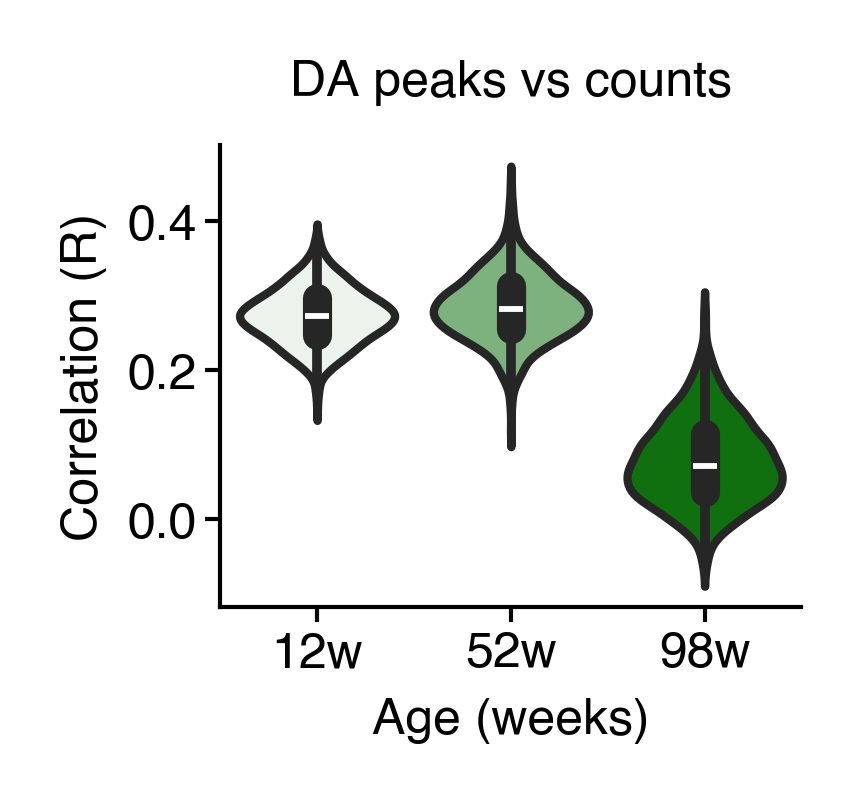

In [88]:
fig = figure(1.25, 1)
ax = sns.violinplot(
    data=correlation_bootstraps.melt(
        var_name="Age (weeks)", value_name="Correlation (R)"
    ),
    x="Age (weeks)",
    y="Correlation (R)",
    hue="Age (weeks)",
    palette=sns.light_palette("green", n_colors=3),
    inner_kws=dict(box_width=3.5, linewidth=1)
)
ax.set(title="DA peaks vs counts")
sns.despine()
saver(fig, 'da-vs-counts-bootstrapped-violinplot');

In [89]:
fun = compose(
    partial(compute_entropy, count_thresh=70, v2=True), partial(compute_tm, max_syll=60)
)
out = filt_df.groupby(['age', 'subject_name', 'uuid']).apply(get_peak_height)
ent_out = filt_df.query("onsets").groupby(["age", "subject_name", "uuid"]).apply(fun)
if isinstance(ent_out, pd.DataFrame):
    ent_out = ent_out.reset_index().melt(id_vars=['age', 'subject_name', 'uuid'], value_name='entropy').set_index(['age', 'subject_name', 'uuid', 'syllables'])
da_ent = pd.DataFrame(ent_out).join(out)
da_ent['Peak DA'] = da_ent.groupby('uuid')['Peak DA'].transform(zscore)
# da_ent['entropy'] = da_ent.groupby('uuid')['entropy'].transform(zscore)

/tmp/ipykernel_15063/1073314887.py:13: RuntimeWarning: Mean of empty slice
  peaks[syll] = np.nanmean(maxes)
/tmp/ipykernel_15063/1171269645.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = filt_df.groupby(['age', 'subject_name', 'uuid']).apply(get_peak_height)
/tmp/ipykernel_15063/1171269645.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ent_out = filt_df.query("onsets").groupby(["age", "subj

In [78]:
da_ent.groupby('age').mean()

,entropy,Peak DA
age,,
12w,1.998742,-3.422655e-17
52w,1.989975,-3.652049e-18
98w,1.866726,-2.991835e-17


In [90]:
correlation_bootstraps = []
for i in tqdm(range(1_000)):
    uuid_sample = uuids.sample(frac=1, replace=True, random_state=i)
    da_ent_sample = []
    for _uuid in uuid_sample:
        da_ent_sample.append(da_ent.loc[pd.IndexSlice[:, :, _uuid], :])
    da_ent_sample = pd.concat(da_ent_sample)
    tmp = da_ent_sample.groupby(['age', 'subject_name', 'syllables']).mean()
    tmp = tmp.groupby('age').corr(method='spearman')
    tmp = tmp.loc[pd.IndexSlice[:, 'entropy'], 'Peak DA'].droplevel(1)
    correlation_bootstraps.append(tmp)
correlation_bootstraps = pd.DataFrame(correlation_bootstraps)

  0%|          | 0/1000 [00:00<?, ?it/s]

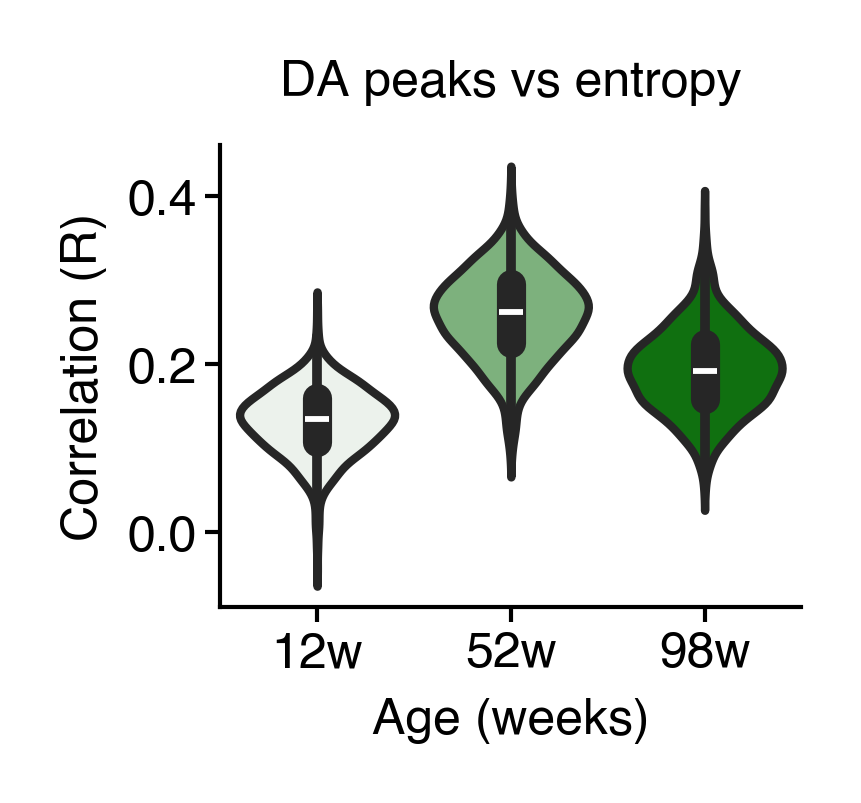

In [92]:
fig = figure(1.25, 1)
ax = sns.violinplot(
    data=correlation_bootstraps.melt(
        var_name="Age (weeks)", value_name="Correlation (R)"
    ),
    x="Age (weeks)",
    y="Correlation (R)",
    hue="Age (weeks)",
    palette=sns.light_palette("green", n_colors=3),
    inner_kws=dict(box_width=3.5, linewidth=1)
)
ax.set(title="DA peaks vs entropy")
sns.despine()
saver(fig, 'da-vs-entropy-bootstrapped-violinplot');

## Usage entropy

In [325]:
out = filt_df.groupby(['age', 'subject_name', 'uuid']).apply(get_peak_height)

/tmp/ipykernel_6063/1584718211.py:13: RuntimeWarning: Mean of empty slice
  peaks[syll] = np.nanmean(maxes)
/tmp/ipykernel_6063/426012510.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = filt_df.groupby(['age', 'subject_name', 'uuid']).apply(get_peak_height_v2)


In [326]:
session_peak_avg = out.groupby(['age', 'subject_name', 'uuid']).mean()

In [337]:
vc = filt_df.query('syllables >= 0').groupby(['age', 'subject_name', 'uuid'])['relabeled_syllables'].value_counts()
# vc = vc[vc >= 42]
u_ent = vc.groupby(['age', 'subject_name', 'uuid']).apply(entropy)
u_ent.name = 'Usage entropy'

In [338]:
u_ent.groupby('age').mean()

age
12w    2.936266
52w    2.835272
98w    2.600729
Name: Usage entropy, dtype: float64

In [331]:
uent_da = pd.DataFrame([u_ent, session_peak_avg]).T

In [332]:
uent_da.groupby('age').corr(method='spearman')

Usage entropy   Peak DA
age                                       
12w Usage entropy       1.000000  0.016121
    Peak DA             0.016121  1.000000
52w Usage entropy       1.000000 -0.626374
    Peak DA            -0.626374  1.000000
98w Usage entropy       1.000000 -0.552217
    Peak DA            -0.552217  1.000000

In [333]:
correlation_bootstraps = []
for i in tqdm(range(500)):
    uuid_sample = uuids.sample(frac=1, replace=True, random_state=i)
    da_ent_sample = []
    for _uuid in uuid_sample:
        da_ent_sample.append(uent_da.loc[pd.IndexSlice[:, :, _uuid], :])
    da_ent_sample = pd.concat(da_ent_sample)
    # tmp = da_ent_sample.groupby(['age', 'subject_name']).mean()
    tmp = da_ent_sample.groupby('age').corr(method='spearman')
    tmp = tmp.loc[pd.IndexSlice[:, 'Usage entropy'], 'Peak DA'].droplevel(1)
    correlation_bootstraps.append(tmp)
correlation_bootstraps = pd.DataFrame(correlation_bootstraps)

  0%|          | 0/500 [00:00<?, ?it/s]

webf NOT subset; don't know how to subset; dropped


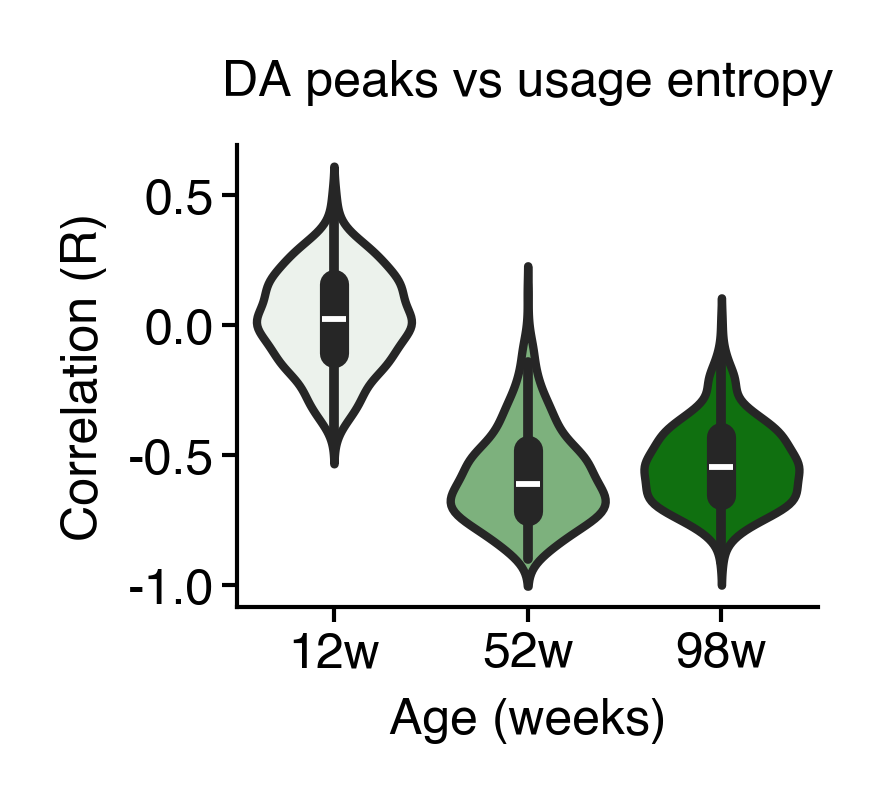

In [335]:
fig = figure(1.25, 1)
ax = sns.violinplot(
    data=correlation_bootstraps.melt(
        var_name="Age (weeks)", value_name="Correlation (R)"
    ),
    x="Age (weeks)",
    y="Correlation (R)",
    hue="Age (weeks)",
    palette=sns.light_palette("green", n_colors=3),
    inner_kws=dict(box_width=3.5, linewidth=1)
)
ax.set(title="DA peaks vs usage entropy")
sns.despine()
saver(fig, 'da-vs-usage-entropy-bootstrapped-violinplot');